In [1]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import seaborn as sns;
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

In [2]:
# Import the dataset

telecom = pd.read_csv(r"C:\Users\MADHUVANTHI\OneDrive\Desktop\Python\Telecom churn casestusy- assignment\telecom_churn_data.csv")
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
# Create a copy of original data
churn_data = telecom.copy()

In [4]:
all_columns = telecom.columns.tolist()
all_columns

['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 's

In [5]:
# check the dimension
telecom.shape

(99999, 226)

We assume that there are three phases of customer lifecycle :

1) The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

2) The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3) The ‘churn’ phase: In this phase, the customer is said to have churned. We define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, we discard all data corresponding to this phase.

In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

High Value Customer
High-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [6]:
# Though we have total amount of recharge for talktime we dont have that number for data, instead we have average and number of rechanrges
# so let's calculate that amount
churn_data['total_data_rech_amt_6'] = churn_data['av_rech_amt_data_6'] * churn_data['total_rech_data_6']
churn_data['total_data_rech_amt_7'] = churn_data['av_rech_amt_data_7'] * churn_data['total_rech_data_7']
churn_data['total_data_rech_amt_8'] = churn_data['av_rech_amt_data_8'] * churn_data['total_rech_data_8']
churn_data['total_data_rech_amt_9'] = churn_data['av_rech_amt_data_9'] * churn_data['total_rech_data_9']

# Drop the columns already accounted for 
churn_data.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'av_rech_amt_data_6',
              'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'], axis=1, inplace=True)

# Find Average recharge amount for good phase i.e 6th and 7th month
good_phase_average_rech_amt = ( churn_data['total_rech_amt_6'].fillna(0) + churn_data['total_rech_amt_7'].fillna(0) + 
                               churn_data['total_data_rech_amt_6'].fillna(0) + churn_data['total_data_rech_amt_7'].fillna(0) ) / 2

# 70 percentile of the good_phase_average_rech_amt data
gd_phase_avg_rech_amt_70 = np.percentile(good_phase_average_rech_amt, 70.0)
print(f'70 Percentile of recharge amount is : {gd_phase_avg_rech_amt_70}')

# Keep high value customer data
churn_data = churn_data[good_phase_average_rech_amt >= gd_phase_avg_rech_amt_70]

print(f'Shape of high value customer data: {churn_data.shape}')


70 Percentile of recharge amount is : 478.0
Shape of high value customer data: (30001, 222)


Tagging Churn
The churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

1) total_ic_mou_9

2) total_og_mou_9

3) vol_2g_mb_9

4) vol_3g_mb_9



In [7]:
# Seperating columns for the 9th month
month9_columns = [col for col in all_columns if '9' in col]

In [8]:
# Seperating the ic columns 
month9_ic_columns = [col for col in month9_columns if 'ic' in col and 'mou' in col]
month9_ic_columns

['roam_ic_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9']

In [9]:
# Seperating oc columns
month9_oc_columns = [col for col in month9_columns if 'oc' in col and 'mou' in col]

In [10]:
# Seperating vol columns
month9_vol_columns = [col for col in month9_columns if 'vol' in col and 'mb' in col]

In [11]:

# Sum of all the ic columns
churn_data['ic_sum'] = telecom[month9_ic_columns].sum(axis = 1)

# Sum of all the oc columns
churn_data['oc_sum'] = telecom[month9_oc_columns].sum(axis = 1)

# Sum of all the vol columns
churn_data['vol_sum'] = telecom[month9_vol_columns].sum(axis = 1)
churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,ic_sum,oc_sum,vol_sum
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0.00,101.20,3.58,252.0,252.0,252.0,NaN,0.00,0.00,0.00
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,19.38,18.74,0.00,NaN,NaN,NaN,NaN,0.00,0.00,0.00
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,910.65,122.16,0.00,NaN,354.0,207.0,NaN,104.72,164.17,0.00
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,757.80,554.79,0.00
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,51.86,0.00,0.00,NaN,712.0,540.0,252.0,382.42,450.31,328.67


In [12]:
churn_tag_columns = ['vol_sum', 'oc_sum', 'ic_sum']

# Create churn as the sum of newly aggregrated columns, as that will be 0 if all of the columns have 0 values
churn_data['churn'] = churn_data[churn_tag_columns].sum(axis = 1)

churn_data.head(15)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,jun_vbc_3g,sep_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,ic_sum,oc_sum,vol_sum,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,101.20,3.58,252.0,252.0,252.0,NaN,0.00,0.00,0.00,0.00
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,18.74,0.00,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,122.16,0.00,NaN,354.0,207.0,NaN,104.72,164.17,0.00,268.89
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,0.00,0.00,NaN,NaN,NaN,NaN,757.80,554.79,0.00,1312.59
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,0.00,0.00,NaN,712.0,540.0,252.0,382.42,450.31,328.67,1161.40
33,7000149764,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,977.020,...,1714.67,0.00,5285.0,20424.0,455.0,1814.0,280.39,36.47,5619.03,5935.89
38,7000815202,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,363.987,...,0.00,0.00,NaN,NaN,NaN,207.0,342.25,233.32,0.00,575.57
41,7000721289,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,482.832,...,0.00,0.00,NaN,NaN,NaN,NaN,355.29,217.00,0.00,572.29
48,7000294396,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1873.271,...,0.00,0.00,NaN,NaN,NaN,NaN,2684.39,3940.49,0.00,6624.88
53,7002188521,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,978.077,...,0.00,0.00,344.0,575.0,23.0,92.0,2041.52,1726.87,0.82,3769.21


In [13]:
# If the churn value is greater than 0 that means the user used a service indicating an active user
churn_data['churn'] = churn_data['churn'].apply(lambda x: 0 if x > 0 else 1)
churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,jun_vbc_3g,sep_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,ic_sum,oc_sum,vol_sum,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,101.20,3.58,252.0,252.0,252.0,NaN,0.00,0.00,0.00,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,18.74,0.00,NaN,NaN,NaN,NaN,0.00,0.00,0.00,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,122.16,0.00,NaN,354.0,207.0,NaN,104.72,164.17,0.00,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,0.00,0.00,NaN,NaN,NaN,NaN,757.80,554.79,0.00,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,0.00,0.00,NaN,712.0,540.0,252.0,382.42,450.31,328.67,0


In [14]:
churn_data.churn.value_counts(normalize=True)

0    0.942369
1    0.057631
Name: churn, dtype: float64

In [15]:

# Dropping Month 9 Columns

churn_data.drop( [ col for col in month9_columns + churn_tag_columns if col not in ['total_rech_data_9', 'av_rech_amt_data_9'] ],
                axis=1, inplace=True)
churn_data.shape

(30001, 171)

#  Data cleaning and EDA

In [16]:
msng_values= round(churn_data.isnull().sum()/len(churn_data)*100, 2).sort_values(ascending = False)
msng_values

total_data_rech_amt_9    49.27
arpu_3g_8                46.83
total_data_rech_amt_8    46.83
fb_user_8                46.83
max_rech_data_8          46.83
                         ...  
vol_2g_mb_6               0.00
vol_2g_mb_7               0.00
vol_2g_mb_8               0.00
vol_3g_mb_6               0.00
churn                     0.00
Length: 171, dtype: float64

In [17]:
# Select columns with more than 40% missing values
drop_msng_col = msng_values[msng_values > 40].index.tolist()
drop_msng_col

['total_data_rech_amt_9',
 'arpu_3g_8',
 'total_data_rech_amt_8',
 'fb_user_8',
 'max_rech_data_8',
 'count_rech_2g_8',
 'count_rech_3g_8',
 'night_pck_user_8',
 'date_of_last_rech_data_8',
 'arpu_2g_8',
 'arpu_3g_6',
 'max_rech_data_6',
 'total_data_rech_amt_6',
 'night_pck_user_6',
 'fb_user_6',
 'count_rech_3g_6',
 'date_of_last_rech_data_6',
 'count_rech_2g_6',
 'arpu_2g_6',
 'date_of_last_rech_data_7',
 'total_data_rech_amt_7',
 'max_rech_data_7',
 'arpu_3g_7',
 'count_rech_2g_7',
 'arpu_2g_7',
 'count_rech_3g_7',
 'night_pck_user_7',
 'fb_user_7']

In [18]:
# Drop columns > 40% missing
churn_data.drop(drop_msng_col, axis=1, inplace=True)
churn_data.shape

(30001, 143)

In [19]:
# Re-check missing values
round(churn_data.isna().sum() / len(churn_data) * 100, 2).sort_values(ascending=False)

loc_ic_mou_8          3.91
og_others_8           3.91
loc_og_t2f_mou_8      3.91
loc_ic_t2t_mou_8      3.91
spl_og_mou_8          3.91
                      ... 
max_rech_amt_6        0.00
max_rech_amt_7        0.00
max_rech_amt_8        0.00
last_day_rch_amt_6    0.00
churn                 0.00
Length: 143, dtype: float64

Since rest of columns have even less than 5% of the data missing we can drop the rows with the missing values

In [20]:
# Drop rows with missing values
for col in churn_data.columns:
    churn_data = churn_data[~churn_data[col].isna()]
    
# Re-check missing values
round(churn_data.isna().sum() / len(churn_data) * 100, 2).sort_values(ascending=False)

mobile_number       0.0
isd_ic_mou_6        0.0
total_ic_mou_6      0.0
total_ic_mou_7      0.0
total_ic_mou_8      0.0
                   ... 
std_og_t2c_mou_7    0.0
std_og_t2c_mou_8    0.0
std_og_mou_6        0.0
std_og_mou_7        0.0
churn               0.0
Length: 143, dtype: float64

In [21]:
# The date columns don't add any value excpet for marking the last day of the period so we will drop them
date_col = [col for col in churn_data.columns if 'date' in col]
churn_data.drop(date_col, axis=1, inplace=True)
[col for col in churn_data.columns if 'date' in col]

[]

In [22]:
print(churn_data.shape)
churn_data.head(20)

(28163, 137)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
7,7000701601,109,0.0,0.0,0.0,1069.180,1349.850,3171.480,57.84,54.68,...,0,0,0,0,802,57.74,19.38,18.74,0.0,1
8,7001524846,109,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,...,0,0,0,0,315,21.03,910.65,122.16,0.0,0
21,7002124215,109,0.0,0.0,0.0,514.453,597.753,637.760,102.41,132.11,...,0,0,0,0,720,0.00,0.00,0.00,0.0,0
23,7000887461,109,0.0,0.0,0.0,74.350,193.897,366.966,48.96,50.66,...,1,0,0,1,604,40.45,51.86,0.00,0.0,0
33,7000149764,109,0.0,0.0,0.0,977.020,2362.833,409.230,0.00,0.00,...,1,1,3,0,1328,358.10,2706.83,1714.67,0.0,0
38,7000815202,109,0.0,0.0,0.0,363.987,486.558,393.909,248.99,619.96,...,0,0,0,0,1155,0.00,0.00,0.00,0.0,0
41,7000721289,109,0.0,0.0,0.0,482.832,425.764,229.769,86.39,118.88,...,0,0,0,0,2010,0.00,0.00,0.00,0.0,0
48,7000294396,109,0.0,0.0,0.0,1873.271,575.927,179.218,2061.69,881.43,...,0,0,0,0,1265,0.00,0.00,0.00,0.0,0
53,7002188521,109,0.0,0.0,0.0,978.077,1141.296,706.020,135.14,119.59,...,0,0,0,0,697,0.00,0.00,0.00,0.0,0
56,7002180748,109,0.0,0.0,0.0,452.624,320.548,368.807,34.46,43.11,...,0,0,0,0,729,277.97,535.63,1459.45,0.0,0


By looking at the dataframe we can see a few of the columns, like circle_id have only value. These kind of feature suggest no variance and hence wont be contributing anything to our target variable.

In [23]:
# Check columns for only 1 unique value
drop_col_sngl_val = []

for col in churn_data.columns:
    if churn_data[f'{col}'].nunique() == 1:
        drop_col_sngl_val.append(col)

drop_col_sngl_val


['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [24]:
# Drop single value columns
churn_data.drop(drop_col_sngl_val, axis=1, inplace=True)
churn_data.shape

(28163, 127)

In [25]:
# Drop the column 'mobile_number' as it does not add any information 
churn_data.drop('mobile_number', axis=1, inplace=True)
churn_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,0,0,0,0,802,57.74,19.38,18.74,0.0,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0,0,0,0,315,21.03,910.65,122.16,0.0,0
21,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.00,...,0,0,0,0,720,0.00,0.00,0.00,0.0,0
23,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.00,...,1,0,0,1,604,40.45,51.86,0.00,0.0,0
33,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1,1,3,0,1328,358.10,2706.83,1714.67,0.0,0


Let us check the correlation between the features and if we find any feature with high correlation we will go ahead and drop them

In [26]:
corr = churn_data.corr()
corr.loc[:, :] = np.tril(corr, -1)
corr = corr.stack()
high_corr_value = corr[(corr > 0.60) | (corr < -0.60)]
high_corr_value

arpu_7       arpu_6         0.728704
arpu_8       arpu_6         0.671437
             arpu_7         0.778413
onnet_mou_7  onnet_mou_6    0.770224
onnet_mou_8  onnet_mou_6    0.646114
                              ...   
aug_vbc_3g   vol_3g_mb_8    0.620313
jul_vbc_3g   vol_3g_mb_7    0.651025
             aug_vbc_3g     0.706559
jun_vbc_3g   vol_3g_mb_6    0.662497
             jul_vbc_3g     0.680020
Length: 207, dtype: float64

In [27]:
# List of columns that are explained well by other columns
drop_col_corr = ['loc_og_t2m_mou_6', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 
                 'std_og_t2m_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 
                 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 
                 'std_ic_t2m_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 
                 'total_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
                 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
                 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8']

# Drop the high corr columns
churn_data.drop(drop_col_corr, axis=1, inplace=True)
churn_data.shape


(28163, 87)

In [28]:
churn_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,0,0,0,0,802,57.74,19.38,18.74,0.0,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0,0,0,0,315,21.03,910.65,122.16,0.0,0
21,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.00,...,0,0,0,0,720,0.00,0.00,0.00,0.0,0
23,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.00,...,1,0,0,1,604,40.45,51.86,0.00,0.0,0
33,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1,1,3,0,1328,358.10,2706.83,1714.67,0.0,0


### Deriving new features

In [29]:
# Create a total mou instead of offnet and onnet

churn_data['total_mou_6'] = churn_data['onnet_mou_6'] + churn_data['offnet_mou_6']
churn_data['total_mou_7'] = churn_data['onnet_mou_7'] + churn_data['offnet_mou_7']
churn_data['total_mou_8'] = churn_data['onnet_mou_8'] + churn_data['offnet_mou_8']

# Drop the redundant columns
churn_data.drop(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], axis=1, inplace=True)

churn_data.head()


,arpu_6,arpu_7,arpu_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2c_mou_6,...,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn,total_mou_6,total_mou_7,total_mou_8
7,1069.180,1349.850,3171.480,16.23,33.49,31.64,23.74,12.59,38.06,0.0,...,0,802,57.74,19.38,18.74,0.0,1,511.27,621.84,378.20
8,378.721,492.223,137.362,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0,315,21.03,910.65,122.16,0.0,0,508.35,431.66,171.56
21,514.453,597.753,637.760,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0,720,0.00,0.00,0.00,0.0,0,860.34,1028.79,1068.53
23,74.350,193.897,366.966,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,1,604,40.45,51.86,0.00,0.0,0,134.37,140.02,239.47
33,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0,1328,358.10,2706.83,1714.67,0.0,0,0.00,0.00,0.00


Since rest of the columns are break out of totals into granualr details we will not merge them into one, instead we will create new features that will each account for the good pahse by averaging out the values for 6th and 7th month

In [30]:
# Seperate columns for 6th and 7th month
col_for_6_7 = [col[:-2] for col in churn_data.columns if '6' in col or '7' in col]

# Create new feature and drop the redundant columns
for col in set(col_for_6_7):
    churn_data[f'gd_ph_{col}'] = ( churn_data[f'{col}_6'] + churn_data[f'{col}_7'] ) / 2
    churn_data.drop([f'{col}_6', f'{col}_7'], axis=1, inplace=True)
        
churn_data.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,...,gd_ph_loc_ic_mou,gd_ph_last_day_rch_amt,gd_ph_vol_2g_mb,gd_ph_spl_og_mou,gd_ph_std_ic_mou,gd_ph_loc_og_mou,gd_ph_isd_ic_mou,gd_ph_arpu,gd_ph_monthly_2g,gd_ph_total_mou
7,3171.480,31.64,38.06,0.00,255.79,16.68,77.84,10.01,6.50,0.0,...,391.555,0.0,0.000,2.25,176.810,478.035,8.295,1209.5150,0.0,566.555
8,137.362,0.00,0.00,7.15,63.04,0.00,98.28,0.00,10.23,0.0,...,52.630,25.0,178.000,0.00,13.545,333.135,0.000,435.4720,0.5,470.005
21,637.760,0.00,0.00,0.00,129.74,0.00,938.79,0.00,0.00,0.0,...,106.505,25.0,0.000,0.00,62.985,95.565,0.000,556.1030,0.0,944.565
23,366.966,0.00,0.00,17.71,182.14,0.00,39.61,0.00,17.71,0.0,...,145.520,89.5,0.240,0.05,8.915,132.795,14.115,134.1235,0.0,137.195
33,409.230,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.56,0.0,...,2.180,126.0,72.405,0.00,4.420,0.000,0.000,1669.9265,0.0,0.000


vbc columns doesn't have number of month as suffix so it seemed to have missed out let's avergae out the columns for this feature too

In [31]:
# Create new column
churn_data['gd_ph_vbc_3g'] = ( churn_data['jul_vbc_3g'] + churn_data['jun_vbc_3g'] ) / 2

# Drop redundant column
churn_data.drop(['jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'], axis=1, inplace=True)

# Rename the august column for vbc to vbc_3g_8
churn_data['vbc_3g_8'] = churn_data['aug_vbc_3g']
churn_data.drop('aug_vbc_3g', axis=1, inplace=True)

churn_data.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,...,gd_ph_vol_2g_mb,gd_ph_spl_og_mou,gd_ph_std_ic_mou,gd_ph_loc_og_mou,gd_ph_isd_ic_mou,gd_ph_arpu,gd_ph_monthly_2g,gd_ph_total_mou,gd_ph_vbc_3g,vbc_3g_8
7,3171.480,31.64,38.06,0.00,255.79,16.68,77.84,10.01,6.50,0.0,...,0.000,2.25,176.810,478.035,8.295,1209.5150,0.0,566.555,19.060,57.74
8,137.362,0.00,0.00,7.15,63.04,0.00,98.28,0.00,10.23,0.0,...,178.000,0.00,13.545,333.135,0.000,435.4720,0.5,470.005,516.405,21.03
21,637.760,0.00,0.00,0.00,129.74,0.00,938.79,0.00,0.00,0.0,...,0.000,0.00,62.985,95.565,0.000,556.1030,0.0,944.565,0.000,0.00
23,366.966,0.00,0.00,17.71,182.14,0.00,39.61,0.00,17.71,0.0,...,0.240,0.05,8.915,132.795,14.115,134.1235,0.0,137.195,25.930,40.45
33,409.230,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.56,0.0,...,72.405,0.00,4.420,0.000,0.000,1669.9265,0.0,0.000,2210.750,358.10


In [32]:
churn_data.shape

(28163, 56)

In [33]:
# Reset the index 
churn_data.reset_index(inplace=True, drop=True)
churn_data.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,...,gd_ph_vol_2g_mb,gd_ph_spl_og_mou,gd_ph_std_ic_mou,gd_ph_loc_og_mou,gd_ph_isd_ic_mou,gd_ph_arpu,gd_ph_monthly_2g,gd_ph_total_mou,gd_ph_vbc_3g,vbc_3g_8
0,3171.480,31.64,38.06,0.00,255.79,16.68,77.84,10.01,6.50,0.0,...,0.000,2.25,176.810,478.035,8.295,1209.5150,0.0,566.555,19.060,57.74
1,137.362,0.00,0.00,7.15,63.04,0.00,98.28,0.00,10.23,0.0,...,178.000,0.00,13.545,333.135,0.000,435.4720,0.5,470.005,516.405,21.03
2,637.760,0.00,0.00,0.00,129.74,0.00,938.79,0.00,0.00,0.0,...,0.000,0.00,62.985,95.565,0.000,556.1030,0.0,944.565,0.000,0.00
3,366.966,0.00,0.00,17.71,182.14,0.00,39.61,0.00,17.71,0.0,...,0.240,0.05,8.915,132.795,14.115,134.1235,0.0,137.195,25.930,40.45
4,409.230,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.56,0.0,...,72.405,0.00,4.420,0.000,0.000,1669.9265,0.0,0.000,2210.750,358.10


In [34]:
churn_data.describe()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,...,gd_ph_vol_2g_mb,gd_ph_spl_og_mou,gd_ph_std_ic_mou,gd_ph_loc_og_mou,gd_ph_isd_ic_mou,gd_ph_arpu,gd_ph_monthly_2g,gd_ph_total_mou,gd_ph_vbc_3g,vbc_3g_8
count,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,...,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000
mean,528.992500,13.145865,20.926258,1.789363,247.845569,1.646062,322.121339,1.989213,6.889342,0.061151,...,127.717157,6.610121,49.261396,263.016895,11.458002,567.163074,0.183397,656.094111,169.310408,173.745705
std,500.479643,76.125433,107.722393,7.390599,367.353912,11.126142,615.275135,45.888765,20.813297,3.421503,...,304.044111,17.610173,135.463961,361.575126,74.792010,431.807280,0.392058,657.870003,395.513994,424.621028
min,-345.129000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-451.713500,0.000000,0.000000,0.000000,0.000000
25%,258.075500,0.000000,0.000000,0.000000,31.410000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.955000,45.762500,0.000000,355.689750,0.000000,178.822500,0.000000,0.000000
50%,445.338000,0.000000,0.000000,0.000000,124.060000,0.000000,34.990000,0.000000,0.700000,0.000000,...,6.505000,1.875000,15.155000,140.590000,0.000000,490.352500,0.000000,499.265000,0.000000,0.000000
75%,675.208500,0.000000,0.000000,0.130000,325.160000,0.000000,392.840000,0.000000,6.640000,0.000000,...,110.375000,7.157500,45.655000,347.185000,0.540000,682.077250,0.000000,922.932500,157.682500,142.470000
max,33543.624000,4169.810000,5337.040000,351.830000,11039.910000,516.910000,13980.060000,5681.540000,954.510000,394.930000,...,7939.075000,1144.500000,5630.410000,6582.420000,5651.025000,31438.461000,4.500000,9344.465000,8190.585000,12916.220000


##### Observation
###### We can see almost every columns has some outliers, while most of them are becuase there are 0.0 as the service was not used some are actual outliers
###### Since we don't have actuall bussines people to check the factfulness of the data, we will cap those features

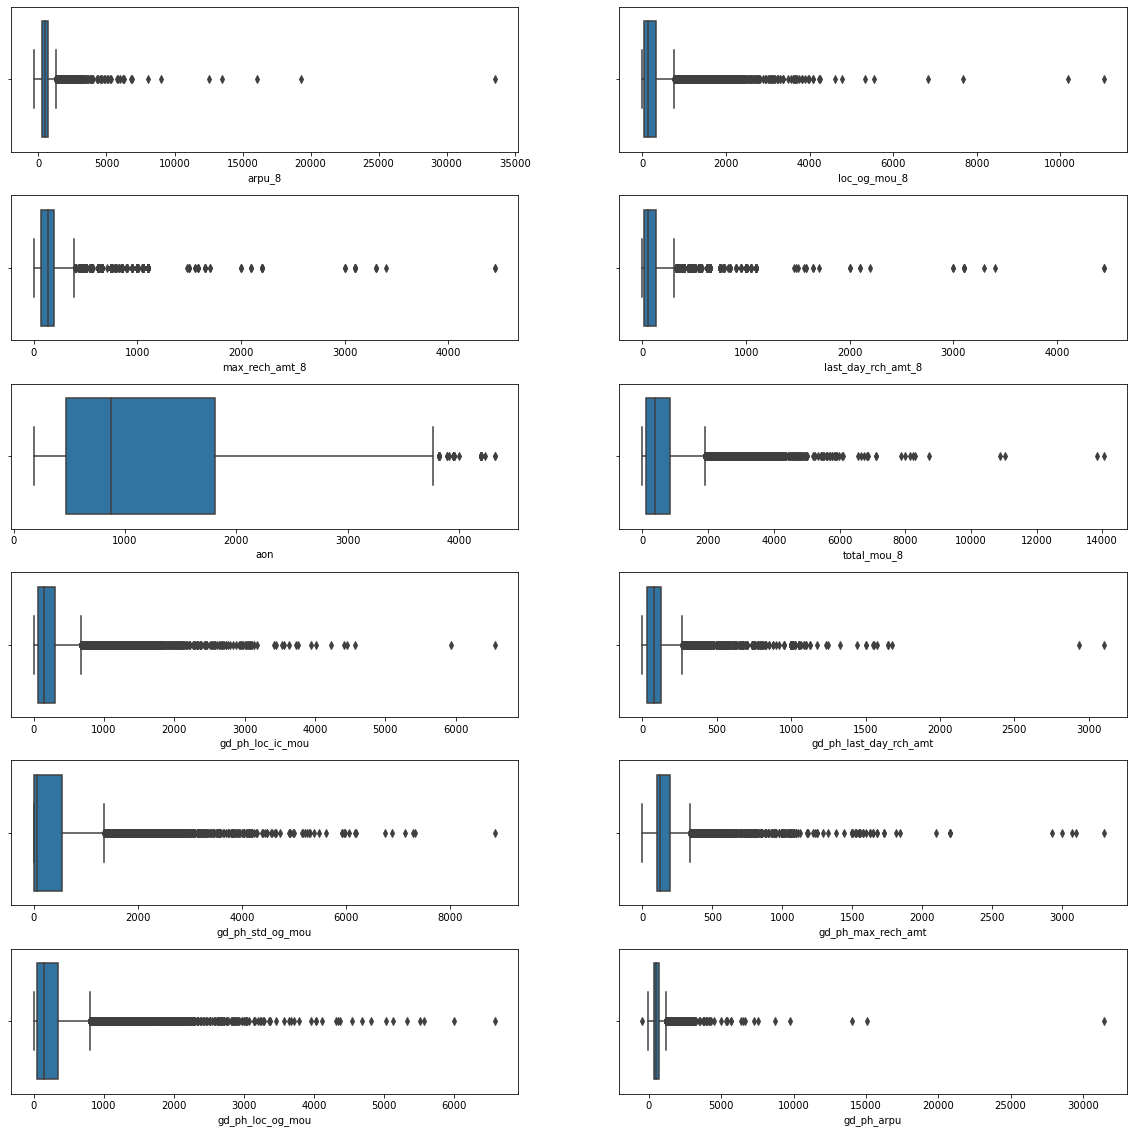

In [35]:
# Going through the output of describe we can filter out the features that needs a second look

# List of features to be analyzed
col_boxplot = ['arpu_8', 'loc_og_mou_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'aon', 'total_mou_8', 
               'gd_ph_loc_ic_mou', 'gd_ph_last_day_rch_amt', 'gd_ph_std_og_mou', 'gd_ph_max_rech_amt', 
              'gd_ph_loc_og_mou', 'gd_ph_arpu']

# Plot boxplots for each variable
fig, axes = plt.subplots(6, 2, figsize=(20, 20))
# sns.boxplot(x=churn_data['arpu_8'], ax=axes[0])
for index, col in enumerate(col_boxplot):
    i, j = divmod(index, 2)
    sns.boxplot(churn_data[col], ax=axes[i, j])
    
plt.subplots_adjust(hspace=0.3) 
plt.show()

Observations

From the above plots we can define following upper limits to the sepected variables

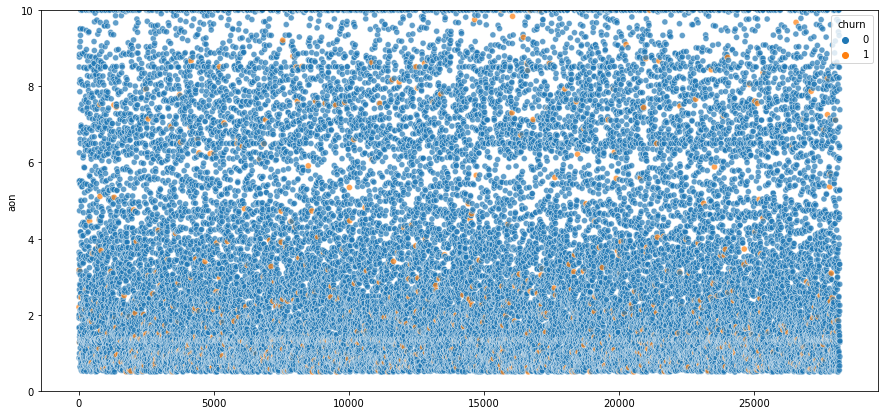

In [36]:
# Check churn based on tenure

plt.figure(figsize=(15,7))
sns.scatterplot(y=churn_data['aon'] / 365, x=churn_data.index, hue=churn_data.churn, alpha=0.7)
plt.ylim(0,10)
plt.show()

Observation

Though we cannot see a clear pattern here, but we can notice that the mojority of churners had a tenure of less than 4 years

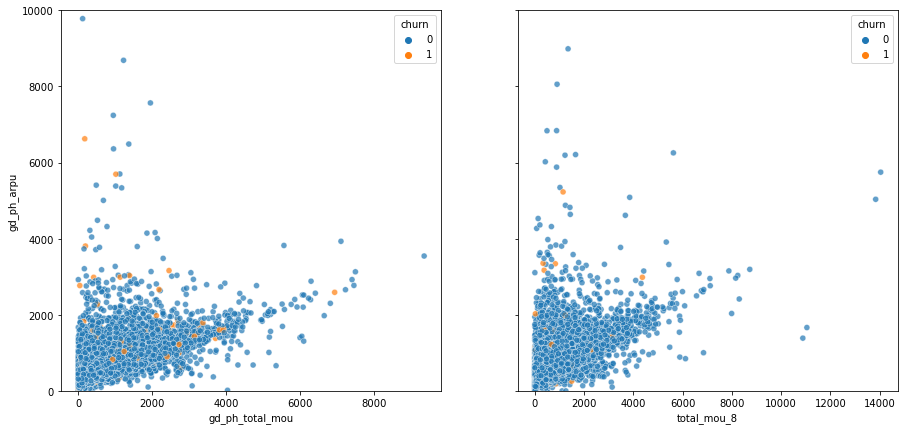

In [37]:
# Lets check how the VBC effects the revenue
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(y='gd_ph_arpu', x='gd_ph_total_mou', data=churn_data, ax=axes[0], hue='churn', alpha=0.7)
sns.scatterplot(y='arpu_8', x='total_mou_8', data=churn_data, ax=axes[1], hue='churn', alpha=0.7)


# Limiting the graph to more general upper bound
plt.ylim(0,10000)
plt.show()

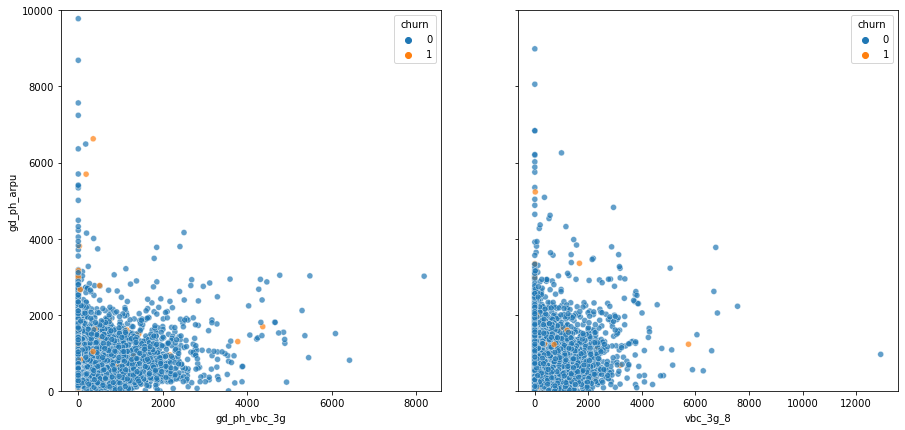

In [38]:
# Lets check how the total_mou effects the revenue
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(y='gd_ph_arpu', x='gd_ph_vbc_3g', data=churn_data, ax=axes[0], hue='churn', alpha=0.7)
sns.scatterplot(y='arpu_8', x='vbc_3g_8', data=churn_data, ax=axes[1], hue='churn', alpha=0.7)


# Limiting the graph to more general upper bound
plt.ylim(0,10000)
plt.show()


Observation

We can see that the users who were using very less amount of VBC data and yet were generating high revenue churned

Yet again we see that the revenue is higher towards the lesser consumption side

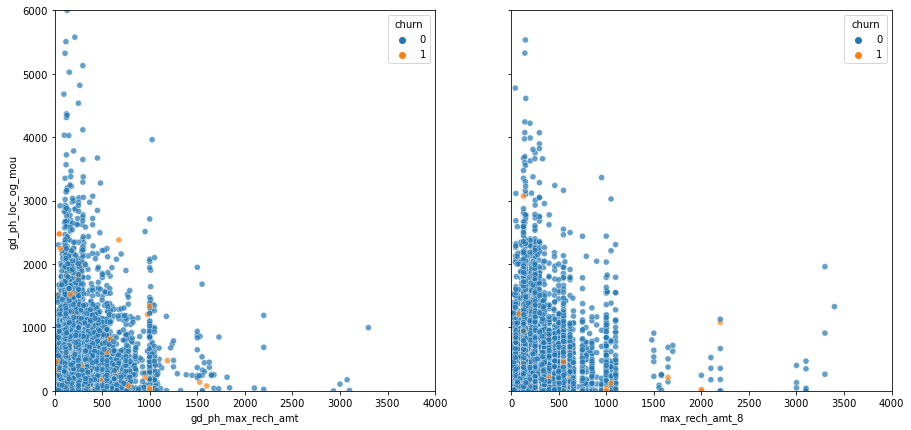

In [39]:
# Lets check the relation between recharge amount and local outgoing calls

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(x='gd_ph_max_rech_amt', y='gd_ph_loc_og_mou', data=churn_data, ax=axes[0],
                hue='churn', alpha=0.7)
sns.scatterplot(x='max_rech_amt_8', y='loc_og_mou_8', data=churn_data, ax=axes[1], hue='churn', alpha=0.7)

# Limiting the graph to more general upper bound
axes[0].set_xlim(0,4000)
axes[1].set_xlim(0,4000)
plt.ylim(0,6000)

plt.show()


Observations

Users who were recharging with high amounts were using the service for local uses less as compared to user who did lesser amounts of recharge

Intuitevly people whose max recharge amount as well as local out going were very less even in the good phase churned more

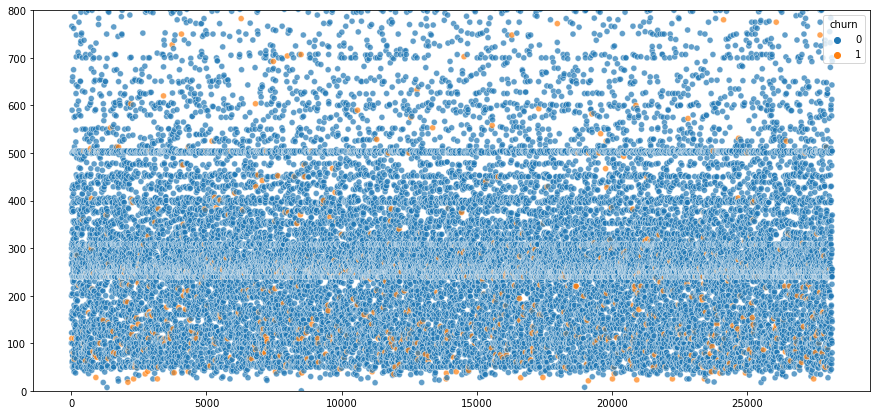

In [40]:
# Check the effect of max recharge amount on churn

plt.figure(figsize=(15,7))
sns.scatterplot(x=churn_data.index, y=churn_data['gd_ph_max_rech_amt'] + churn_data['max_rech_amt_8'],
                hue=churn_data['churn'], alpha=0.7)
plt.ylim(0,800)
plt.show()

Observation

We can see that users who had the max recharge amount less tha 200 churned more


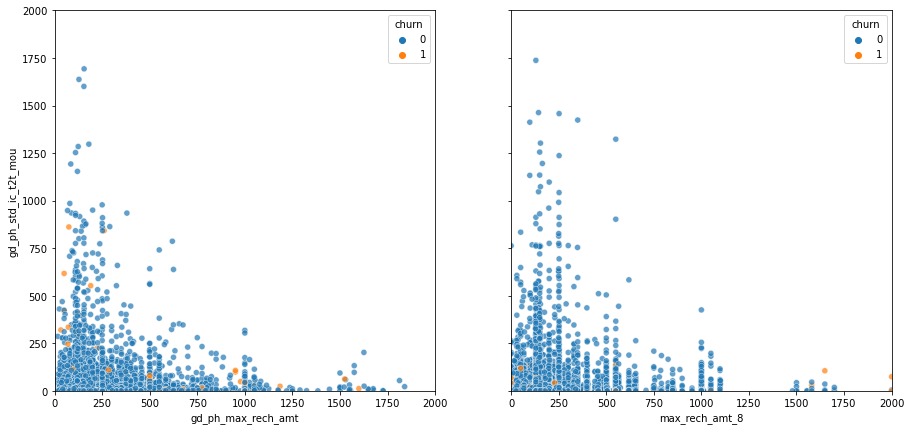

In [41]:
# Incoming from the same service provider vs the recharge amount

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(x='gd_ph_max_rech_amt', y='gd_ph_std_ic_t2t_mou', data=churn_data, ax=axes[0],
                hue='churn', alpha=0.7)
sns.scatterplot(x='max_rech_amt_8', y='std_ic_t2t_mou_8', data=churn_data, ax=axes[1], hue='churn', alpha=0.7)

# Limiting the graph to more general upper bound
axes[0].set_xlim(0,2000)
axes[1].set_xlim(0,2000)
plt.ylim(0,2000)

plt.show()


Observation

Users who have max recharge amount on the higher end and still have low incoming call mou during the good pahse, churned out more

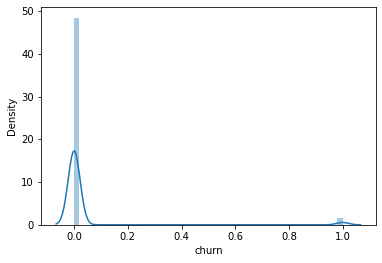

In [42]:
# Distribution of target variable

sns.distplot(churn_data['churn'])
plt.show()

Observation

Though the varible is not skwed it is higly imbalanced, the number of non-churners in the dataset is around 94%

We will handle this imbalance using SMOTE algorithm


### Data Preperation 

In [43]:

# Cap the features with high outliers

col_upr_lmt = [('arpu_8', 7000), ('loc_og_mou_8', 4000), ('max_rech_amt_8', 1000 ), ('last_day_rch_amt_8', 1000 ), 
               ('aon', 3000), ('total_mou_8', 4000), ('gd_ph_loc_ic_mou', 3000), ('gd_ph_last_day_rch_amt', 1000 ), 
               ('gd_ph_std_og_mou', 4000), ('gd_ph_max_rech_amt', 1500), ('gd_ph_loc_og_mou', 3000), ('gd_ph_arpu', 7000)]

for col, value in col_upr_lmt:
    churn_data[col] = churn_data[col].apply(lambda x : x if x < value else value)

churn_data[col_boxplot].head()

,arpu_8,loc_og_mou_8,max_rech_amt_8,last_day_rch_amt_8,aon,total_mou_8,gd_ph_loc_ic_mou,gd_ph_last_day_rch_amt,gd_ph_std_og_mou,gd_ph_max_rech_amt,gd_ph_loc_og_mou,gd_ph_arpu
0,3171.480,255.79,1000,779,802,378.20,391.555,0.0,68.000,1185.0,478.035,1209.5150
1,137.362,63.04,30,10,315,171.56,52.630,25.0,136.870,122.0,333.135,435.4720
2,637.760,129.74,50,50,720,1068.53,106.505,25.0,848.990,50.0,95.565,556.1030
3,366.966,182.14,179,0,604,239.47,145.520,89.5,4.355,89.5,132.795,134.1235
4,409.230,0.00,455,455,1328,0.00,2.180,126.0,0.000,753.5,0.000,1669.9265


In [44]:
y = churn_data['churn']
X = churn_data.drop('churn', axis=1)

#### Standardisation

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

### Handling Class Imbalance

In [46]:
churn_data.churn.value_counts()

0    27295
1      868
Name: churn, dtype: int64

In [47]:
# Use SMOTE to take care of class imbalance
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [48]:
y_res.value_counts()

1    27295
0    27295
Name: churn, dtype: int64

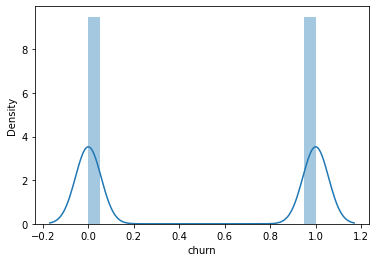

In [49]:
sns.distplot(y_res)
plt.show()

Now the class is balanced and the target variable is not skwed

### PCA

In [50]:
X.shape

(28163, 55)

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25)
X_pca = pca.fit_transform(X_res)
X_pca.shape

(54590, 25)

### MODEL BUILDING 

1. Logistic Regression

For logistic regression we will be using the unaltered X and y so that we can use RFE for feature selection instead of PCA, to find out the strong predictor of churn

In [52]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.7, test_size=0.3, random_state=25)

In [53]:
import statsmodels.api as sm

In [54]:
# Initial logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38157
Model Family:                Binomial   Df Model:                           55
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17495.
Date:                Wed, 28 Dec 2022   Deviance:                       34989.
Time:                        20:36:22   Pearson chi2:                 1.39e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.4263      0.022    -64.034      0.000      -1.470      -1.383
arpu_8                     0.4480      0.049      9.143      0.000       0.352       0.544
roam_ic_mou_8             -0.4067      0.034    -12.125      0.000      -0.472      -0.341
roam_og_mou_8             -0.0466      0.033     -1.415      0.157      -0.111       0.018
loc_og_t2c_mou_8           0.0717      0.024      3.032      0.002       0.025       0.118
loc_og_mou_8              -0.3651      0.093     -3.938      0.000      -0.547      -0.183
std_og_t2f_mou_8          -0.1397      0.041     -3.389      0.001      -0.221      -0.059
std_og_mou_8              -0.0983      0.131     -0.750      0.453      -0.355       0.158
isd_og_mou_8              -0.2239      0.069     -3.243      0.001      -0.359      -0.089
spl_og_mou_8              -0.1959      0.035     -5.623      0.000      -0.264      -0.128
og_others_8                0.0873      0.024      3.681      0.000       0.041       0.134
loc_ic_mou_8              -1.6866      0.059    -28.677      0.000      -1.802      -1.571
std_ic_t2t_mou_8          -0.5831      0.065     -8.985      0.000      -0.710      -0.456
std_ic_t2f_mou_8          -0.0224      0.040     -0.566      0.572      -0.100       0.055
std_ic_mou_8              -0.1598      0.045     -3.583      0.000      -0.247      -0.072
spl_ic_mou_8              -0.2152      0.021    -10.012      0.000      -0.257      -0.173
isd_ic_mou_8              -0.1573      0.028     -5.596      0.000      -0.212      -0.102
ic_others_8                0.1748      0.032      5.529      0.000       0.113       0.237
total_rech_num_8          -0.4986      0.034    -14.620      0.000      -0.565      -0.432
max_rech_amt_8             0.1899      0.024      7.817      0.000       0.142       0.238
last_day_rch_amt_8        -0.5462      0.022    -25.311      0.000      -0.589      -0.504
vol_2g_mb_8               -0.2947      0.030     -9.743      0.000      -0.354      -0.235
monthly_2g_8              -0.5893      0.028    -20.864      0.000      -0.645      -0.534
sachet_2g_8               -0.6012      0.030    -19.878      0.000      -0.661      -0.542
monthly_3g_8              -0.9116      0.038    -24.171      0.000      -0.986      -0.838
sachet_3g_8               -0.3841      0.035    -10.977      0.000      -0.453      -0.316
aon                       -0.3977      0.017    -24.089      0.000      -0.430      -0.365
total_mou_8               -0.7591      0.146     -5.209      0.000      -1.045      -0.474
gd_ph_spl_ic_mou          -0.0425      0.024     -1.757      0.079      -0.090       0.005
gd_ph_ic_others           -0.4325      0.064     -6.779      0.000      -0.558      -0.307
gd_ph_total_rech_num       0.3355      0.027     12.342      0.000       0.282  

RFE for Feature selection

In [56]:

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


In [57]:
# Create LR object
logreg = LogisticRegression(solver='liblinear')


In [59]:
# Run RFE for 25 features
rfe = RFE(logreg, n_features_to_select=25)
rfe = rfe.fit(X_train, y_train)

In [60]:
rfe_col = X.columns[rfe.support_]
rfe_col

Index(['arpu_8', 'roam_ic_mou_8', 'loc_og_mou_8', 'loc_ic_mou_8',
       'std_ic_t2t_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'total_mou_8',
       'gd_ph_total_rech_num', 'gd_ph_roam_og_mou', 'gd_ph_sachet_3g',
       'gd_ph_monthly_3g', 'gd_ph_std_og_mou', 'gd_ph_loc_ic_mou',
       'gd_ph_vol_2g_mb', 'gd_ph_loc_og_mou', 'gd_ph_total_mou'],
      dtype='object')

In [61]:
#Build model with RFE selected features
X_train_sm = sm.add_constant(X_train[rfe_col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38187
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17764.
Date:                Wed, 28 Dec 2022   Deviance:                       35528.
Time:                        20:39:16   Pearson chi2:                 1.92e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.3573      0.021    -63.458      0.000      -1.399      -1.315
arpu_8                   0.3533      0.033     10.825      0.000       0.289       0.417
roam_ic_mou_8           -0.3624      0.026    -14.202      0.000      -0.412      -0.312
loc_og_mou_8            -0.2828      0.047     -6.008      0.000      -0.375      -0.191
loc_ic_mou_8            -1.7448      0.058    -30.105      0.000      -1.858      -1.631
std_ic_t2t_mou_8        -0.3962      0.042     -9.417      0.000      -0.479      -0.314
spl_ic_mou_8            -0.2286      0.021    -10.804      0.000      -0.270      -0.187
total_rech_num_8        -0.5703      0.032    -17.630      0.000      -0.634      -0.507
max_rech_amt_8           0.2382      0.022     10.779      0.000       0.195       0.282
last_day_rch_amt_8      -0.5497      0.021    -26.072      0.000      -0.591      -0.508
vol_2g_mb_8             -0.2671      0.030     -8.989      0.000      -0.325      -0.209
monthly_2g_8            -0.6972      0.025    -27.787      0.000      -0.746      -0.648
sachet_2g_8             -0.4703      0.023    -20.526      0.000      -0.515      -0.425
monthly_3g_8            -0.9591      0.036    -26.835      0.000      -1.029      -0.889
sachet_3g_8             -0.4200      0.035    -11.884      0.000      -0.489      -0.351
aon                     -0.3985      0.016    -24.794      0.000      -0.430      -0.367
total_mou_8             -0.8328      0.037    -22.587      0.000      -0.905      -0.761
gd_ph_total_rech_num     0.3806      0.024     15.949      0.000       0.334       0.427
gd_ph_roam_og_mou        0.3068      0.033      9.295      0.000       0.242       0.371
gd_ph_sachet_3g          0.2044      0.022      9.505      0.000       0.162       0.247
gd_ph_monthly_3g         0.2872      0.023     12.505      0.000       0.242       0.332
gd_ph_std_og_mou         1.0200      0.179      5.697      0.000       0.669       1.371
gd_ph_loc_ic_mou         0.8521      0.040     21.334      0.000       0.774       0.930
gd_ph_vol_2g_mb          0.2244      0.020     11.169      0.000       0.185       0.264
gd_ph_loc_og_mou         0.7534      0.113      6.663      0.000       0.532       0.975
gd_ph_total_mou         -0.8290      0.203     -4.078      0.000      -1.227      -0.431
========================================================================================
"""

In [62]:
# Predict on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,1,0.543166,1
1,1,0.789861,1
2,1,0.964418,1
3,0,0.118026,0
4,0,0.848026,1


In [63]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[14754  4326]
 [ 3450 15683]]

Accuracy : 0.7965090414256928


In [64]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
24,gd_ph_total_mou,91.27
20,gd_ph_std_og_mou,82.36
23,gd_ph_loc_og_mou,24.76
15,total_mou_8,4.40
2,loc_og_mou_8,4.33
0,arpu_8,4.28
3,loc_ic_mou_8,3.76
21,gd_ph_loc_ic_mou,3.40
6,total_rech_num_8,3.30
17,gd_ph_roam_og_mou,3.01


Since the VIF for total_mou_8 is very high we will drop it

In [65]:
rfe_col = rfe_col.drop('total_mou_8', 1)

In [66]:
# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38188
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18052.
Date:                Wed, 28 Dec 2022   Deviance:                       36105.
Time:                        20:39:36   Pearson chi2:                 1.10e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.3479      0.021    -62.743      0.000      -1.390      -1.306
arpu_8                   0.0137      0.028      0.497      0.619      -0.040       0.068
roam_ic_mou_8           -0.3326      0.025    -13.514      0.000      -0.381      -0.284
loc_og_mou_8            -0.5497      0.045    -12.225      0.000      -0.638      -0.462
loc_ic_mou_8            -1.8220      0.058    -31.158      0.000      -1.937      -1.707
std_ic_t2t_mou_8        -0.4532      0.043    -10.560      0.000      -0.537      -0.369
spl_ic_mou_8            -0.2311      0.021    -10.940      0.000      -0.272      -0.190
total_rech_num_8        -0.8250      0.031    -26.361      0.000      -0.886      -0.764
max_rech_amt_8           0.2983      0.022     13.760      0.000       0.256       0.341
last_day_rch_amt_8      -0.5586      0.021    -26.687      0.000      -0.600      -0.518
vol_2g_mb_8             -0.2546      0.030     -8.582      0.000      -0.313      -0.196
monthly_2g_8            -0.6729      0.025    -26.657      0.000      -0.722      -0.623
sachet_2g_8             -0.4325      0.023    -18.730      0.000      -0.478      -0.387
monthly_3g_8            -0.8842      0.036    -24.845      0.000      -0.954      -0.814
sachet_3g_8             -0.3584      0.035    -10.117      0.000      -0.428      -0.289
aon                     -0.3854      0.016    -24.087      0.000      -0.417      -0.354
gd_ph_total_rech_num     0.5609      0.023     24.425      0.000       0.516       0.606
gd_ph_roam_og_mou        0.2094      0.029      7.238      0.000       0.153       0.266
gd_ph_sachet_3g          0.1709      0.021      7.981      0.000       0.129       0.213
gd_ph_monthly_3g         0.2918      0.023     12.718      0.000       0.247       0.337
gd_ph_std_og_mou         0.3070      0.153      2.002      0.045       0.006       0.607
gd_ph_loc_ic_mou         0.9300      0.040     22.986      0.000       0.851       1.009
gd_ph_vol_2g_mb          0.2082      0.020     10.382      0.000       0.169       0.248
gd_ph_loc_og_mou         0.4916      0.099      4.963      0.000       0.297       0.686
gd_ph_total_mou         -0.3933      0.176     -2.232      0.026      -0.739      -0.048
========================================================================================
"""

In [67]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')


[[14754  4326]
 [ 3450 15683]]

Accuracy : 0.7965090414256928


In [68]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
23,gd_ph_total_mou,91.26
19,gd_ph_std_og_mou,81.29
22,gd_ph_loc_og_mou,24.74
2,loc_og_mou_8,3.86
3,loc_ic_mou_8,3.76
0,arpu_8,3.46
20,gd_ph_loc_ic_mou,3.40
16,gd_ph_roam_og_mou,3.00
6,total_rech_num_8,2.89
7,max_rech_amt_8,2.62


In [69]:
# Drop 'gd_ph_total_mou'
rfe_col = rfe_col.drop('gd_ph_total_mou', 1)

In [70]:
# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38189
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18055.
Date:                Wed, 28 Dec 2022   Deviance:                       36110.
Time:                        20:39:54   Pearson chi2:                 1.16e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.3460      0.021    -62.748      0.000      -1.388      -1.304
arpu_8                  -0.0008      0.027     -0.030      0.976      -0.054       0.052
roam_ic_mou_8           -0.3312      0.025    -13.461      0.000      -0.379      -0.283
loc_og_mou_8            -0.5457      0.045    -12.173      0.000      -0.634      -0.458
loc_ic_mou_8            -1.8187      0.058    -31.140      0.000      -1.933      -1.704
std_ic_t2t_mou_8        -0.4522      0.043    -10.551      0.000      -0.536      -0.368
spl_ic_mou_8            -0.2314      0.021    -10.953      0.000      -0.273      -0.190
total_rech_num_8        -0.8164      0.031    -26.320      0.000      -0.877      -0.756
max_rech_amt_8           0.2983      0.022     13.771      0.000       0.256       0.341
last_day_rch_amt_8      -0.5565      0.021    -26.624      0.000      -0.597      -0.515
vol_2g_mb_8             -0.2538      0.030     -8.560      0.000      -0.312      -0.196
monthly_2g_8            -0.6726      0.025    -26.643      0.000      -0.722      -0.623
sachet_2g_8             -0.4341      0.023    -18.805      0.000      -0.479      -0.389
monthly_3g_8            -0.8810      0.036    -24.782      0.000      -0.951      -0.811
sachet_3g_8             -0.3581      0.035    -10.120      0.000      -0.427      -0.289
aon                     -0.3849      0.016    -24.061      0.000      -0.416      -0.354
gd_ph_total_rech_num     0.5556      0.023     24.357      0.000       0.511       0.600
gd_ph_roam_og_mou        0.1548      0.015     10.051      0.000       0.125       0.185
gd_ph_sachet_3g          0.1705      0.021      7.973      0.000       0.129       0.212
gd_ph_monthly_3g         0.2910      0.023     12.687      0.000       0.246       0.336
gd_ph_std_og_mou        -0.0339      0.015     -2.232      0.026      -0.064      -0.004
gd_ph_loc_ic_mou         0.9286      0.040     22.957      0.000       0.849       1.008
gd_ph_vol_2g_mb          0.2070      0.020     10.330      0.000       0.168       0.246
gd_ph_loc_og_mou         0.2826      0.032      8.747      0.000       0.219       0.346
========================================================================================
"""

In [71]:
# Predict on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,1,0.466016,0
1,1,0.797215,1
2,1,0.899932,1
3,0,0.141638,0
4,0,0.832749,1


In [72]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')


[[14495  4585]
 [ 3381 15752]]

Accuracy : 0.7915369115222568


In [73]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,loc_og_mou_8,3.85
3,loc_ic_mou_8,3.75
20,gd_ph_loc_ic_mou,3.40
0,arpu_8,3.35
22,gd_ph_loc_og_mou,3.32
6,total_rech_num_8,2.87
7,max_rech_amt_8,2.62
15,gd_ph_total_rech_num,2.22
8,last_day_rch_amt_8,1.98
12,monthly_3g_8,1.89


In [74]:
# Drop 'loc_ic_mou_8'
rfe_col = rfe_col.drop('loc_ic_mou_8', 1)


In [75]:
# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38190
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18683.
Date:                Wed, 28 Dec 2022   Deviance:                       37366.
Time:                        20:40:14   Pearson chi2:                 5.09e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.1929      0.020    -60.009      0.000      -1.232      -1.154
arpu_8                  -0.0415      0.027     -1.528      0.126      -0.095       0.012
roam_ic_mou_8           -0.2677      0.024    -11.072      0.000      -0.315      -0.220
loc_og_mou_8            -1.2821      0.045    -28.205      0.000      -1.371      -1.193
std_ic_t2t_mou_8        -0.5177      0.044    -11.883      0.000      -0.603      -0.432
spl_ic_mou_8            -0.2519      0.021    -11.813      0.000      -0.294      -0.210
total_rech_num_8        -0.9454      0.031    -30.412      0.000      -1.006      -0.884
max_rech_amt_8           0.2900      0.021     13.549      0.000       0.248       0.332
last_day_rch_amt_8      -0.5489      0.021    -26.576      0.000      -0.589      -0.508
vol_2g_mb_8             -0.2870      0.030     -9.642      0.000      -0.345      -0.229
monthly_2g_8            -0.6873      0.025    -27.694      0.000      -0.736      -0.639
sachet_2g_8             -0.4413      0.023    -19.190      0.000      -0.486      -0.396
monthly_3g_8            -0.8774      0.035    -25.152      0.000      -0.946      -0.809
sachet_3g_8             -0.3912      0.036    -10.918      0.000      -0.461      -0.321
aon                     -0.3938      0.016    -25.338      0.000      -0.424      -0.363
gd_ph_total_rech_num     0.6321      0.023     27.814      0.000       0.588       0.677
gd_ph_roam_og_mou        0.1419      0.016      9.074      0.000       0.111       0.173
gd_ph_sachet_3g          0.1791      0.021      8.358      0.000       0.137       0.221
gd_ph_monthly_3g         0.2794      0.022     12.455      0.000       0.235       0.323
gd_ph_std_og_mou        -0.0007      0.015     -0.044      0.965      -0.030       0.029
gd_ph_loc_ic_mou        -0.1263      0.019     -6.575      0.000      -0.164      -0.089
gd_ph_vol_2g_mb          0.2151      0.020     10.971      0.000       0.177       0.254
gd_ph_loc_og_mou         0.6496      0.032     20.108      0.000       0.586       0.713
========================================================================================
"""

In [76]:
# Predict on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,1,0.461893,0
1,1,0.714368,1
2,1,0.912574,1
3,0,0.190462,0
4,0,0.819353,1


In [77]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')


[[14326  4754]
 [ 3554 15579]]

Accuracy : 0.782587077696072


In [78]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,arpu_8,3.35
2,loc_og_mou_8,3.30
21,gd_ph_loc_og_mou,3.07
5,total_rech_num_8,2.83
6,max_rech_amt_8,2.62
14,gd_ph_total_rech_num,2.18
7,last_day_rch_amt_8,1.98
11,monthly_3g_8,1.89
8,vol_2g_mb_8,1.84
17,gd_ph_monthly_3g,1.82


The VIF values looks good now, we can proceed further

In [79]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [80]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8142476349762191

In [81]:
# Let us calculate specificity
TN / float(TN+FP)

0.7508385744234801

In [82]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.2491614255765199


In [83]:
# positive predictive value 
print (TP / float(TP+FP))

0.7661928884080067


In [84]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8012304250559285


PLotting ROC

In [85]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

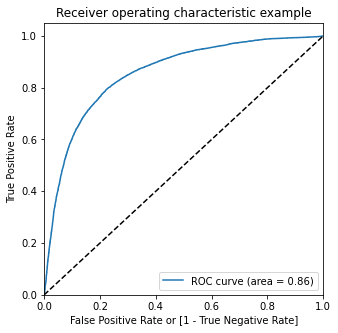

In [86]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

Optimal Cut off

In [87]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.461893,0,1,1,1,1,1,0,0,0,0,0
1,1,0.714368,1,1,1,1,1,1,1,1,1,0,0
2,1,0.912574,1,1,1,1,1,1,1,1,1,1,1
3,0,0.190462,0,1,1,0,0,0,0,0,0,0,0
4,0,0.819353,1,1,1,1,1,1,1,1,1,1,0


In [88]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5, 0.5, 0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500693  1.000000  0.000000
0.1   0.1  0.615759  0.982021  0.248480
0.2   0.2  0.683589  0.952804  0.413627
0.3   0.3  0.732133  0.919720  0.544025
0.4   0.4  0.764897  0.874353  0.655136
0.5   0.5  0.782587  0.814248  0.750839
0.6   0.6  0.778714  0.722574  0.835010
0.7   0.7  0.748489  0.593686  0.903721
0.8   0.8  0.666396  0.376888  0.956709
0.9   0.9  0.545416  0.102754  0.989308


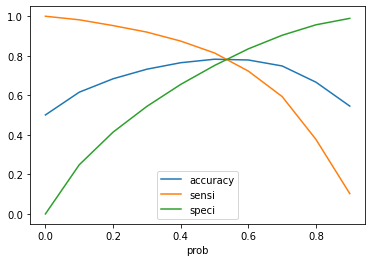

In [89]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()


The point 0.5 is optimal for our model, so we will keep that

In [90]:
X_test = X_test[rfe_col]
X_test_sm = sm.add_constant(X_test)

# Predict on test data

y_test_pred = res.predict(X_test_sm)
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final.head()

,Churn,Churn_Prob,predicted
38017,1,0.828090,1
7994,0,0.232186,0
51540,1,0.826804,1
26903,0,0.562782,1
15570,0,0.427217,0


In [91]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.predicted)}')

[[6186 2029]
 [1538 6624]]

Accuracy : 0.7821945411247482


In [92]:
# Top 10 predictors

abs(res.params).sort_values(ascending=False)[0:11]

loc_og_mou_8            1.282065
const                   1.192894
total_rech_num_8        0.945401
monthly_3g_8            0.877368
monthly_2g_8            0.687312
gd_ph_loc_og_mou        0.649594
gd_ph_total_rech_num    0.632090
last_day_rch_amt_8      0.548943
std_ic_t2t_mou_8        0.517678
sachet_2g_8             0.441314
aon                     0.393760
dtype: float64

So using Logistic regression we are geting an accuracy of 78.5% on train data and 78.8% on test data

We can clearly see most of the critical features are form the action phase, which is inline with the bussiness understanding that action phase needs more attention

### 2. Decision Tree

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, train_size=0.7, random_state=25)

In [94]:
from sklearn.tree import DecisionTreeClassifier

# Initial classifier
intial_dt = DecisionTreeClassifier(random_state=42, max_depth=10)
intial_dt.fit(X_train, y_train)

# Train Accuracy
y_train_pred = intial_dt.predict(X_train)
print(f'Train accuracy : {metrics.accuracy_score(y_train, y_train_pred)}')

y_test_pred = intial_dt.predict(X_test)

# Print the report on test data
print(metrics.classification_report(y_test, y_test_pred))

Train accuracy : 0.8796221181273388
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      8215
           1       0.81      0.90      0.85      8162

    accuracy                           0.85     16377
   macro avg       0.85      0.85      0.84     16377
weighted avg       0.85      0.85      0.84     16377



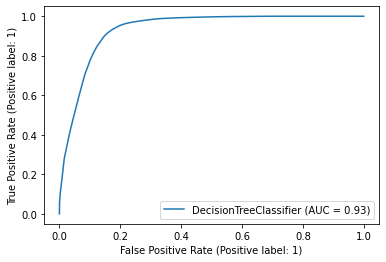

In [95]:
# Plot ROC curve
from sklearn.metrics import plot_roc_curve
plot_roc_curve(intial_dt, X_train, y_train, drop_intermediate=False)
plt.show()

###### Hyperparameter Tuning

In [96]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=42)


In [97]:

# Define parameters
params = {
    "max_depth": [2, 3, 5, 10, 20, 30, 40, 50, 100],
    "min_samples_leaf": [5, 10, 20, 50, 100, 250, 500, 800, 1000],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")


In [98]:

# Perform gridsearch
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20, 30, 40, 50, 100],
                         'min_samples_leaf': [1, 5, 10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [99]:
grid_search.best_score_


0.8854317618654988

In [100]:
# Best estimator
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=50, random_state=42)

In [101]:
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      8215
           1       0.87      0.92      0.90      8162

    accuracy                           0.90     16377
   macro avg       0.90      0.90      0.90     16377
weighted avg       0.90      0.90      0.90     16377



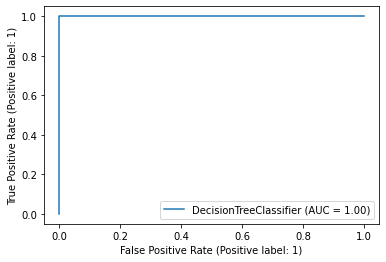

In [102]:
# ROC
plot_roc_curve(dt_best, X_train, y_train)
plt.show()

We are getting an accuracy of 90% on test data, with decission tree

### 3. Random Forest

Train accuracy : 0.8796221181273388
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      8215
           1       0.87      0.93      0.90      8162

    accuracy                           0.90     16377
   macro avg       0.90      0.90      0.90     16377
weighted avg       0.90      0.90      0.90     16377



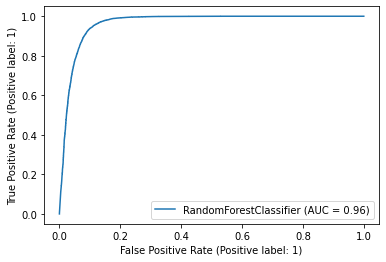

In [103]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=15, max_depth=10, max_features=5, random_state=25, oob_score=True)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)

# Train Accuracy
y_train_pred = intial_dt.predict(X_train)
print(f'Train accuracy : {metrics.accuracy_score(y_train, y_train_pred)}')

y_test_pred = rf.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))

# Plotting ROC
plot_roc_curve(rf, X_train, y_train)
plt.show()

Hyperparameter tuning

In [ ]:
rf = RandomForestClassifier(random_state=25, n_jobs=-1)

# Define parameters
params = {
    'max_depth': [2, 3, 5, 10, 20, 30],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'n_estimators': [10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_score_

In [ ]:
rf_best = grid_search.best_estimator_
rf_best

In [ ]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)


# Print the report
print(metrics.classification_report(y_test, y_test_pred))

In [ ]:
plot_roc_curve(rf_best, X_train, y_train)
plt.show()

We are getting an accuracy of 95% on test data, with Random forest

### Conclusions


Given our bussines probelm, to retain their customers, we need higher recall. As giving an offer to an user not going to churn will cost less as compared to loosing a customer and bring new customer, we need to have high rate of correctly identifying the true positives, hence recall.

When we compare the models trained we can see the tuned random forest and ada boost are performing the best, which is highest accuracy along with highest recall i.e. 95% and 97% respectively. So, we will go with random forest instead of adaboost as that is comparetively simpler model.

### Strategies to Manage Customer Churn


The top 10 predictors are :

Features

loc_og_mou_8
total_rech_num_8
monthly_3g_8
monthly_2g_8
gd_ph_loc_og_mou
gd_ph_total_rech_num
last_day_rch_amt_8
std_ic_t2t_mou_8
sachet_2g_8
aon

We can see most of the top predictors are from the action phase, as the drop in engagement is prominent in that phase

Some of the factors we noticed while performing EDa which can be clubed with these insights are:

1) Users whose maximum recharge amount is less than 200 even in the good pahse, should have a tag and re-evaluated time to time as they are more likely to churn

2) Users that have been with the network less than 4 years, should be monitored time to time, as from data we can see that users who have been associated with the network for less than 4 years tend to churn more

3) MOU is one of the major factors, but data especially VBC if the user is not using a data pack if another factor to look out